Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading
- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Simple guide to confusion matrix terminology](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/) by Kevin Markham, with video
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)
- [ ] Stacking Ensemble. (See below)

### Stacking Ensemble

Here's some code you can use to "stack" multiple submissions, which is another form of ensembling:

```python
import pandas as pd

# Filenames of your submissions you want to ensemble
files = ['submission-01.csv', 'submission-02.csv', 'submission-03.csv']

target = 'status_group'
submissions = (pd.read_csv(file)[[target]] for file in files)
ensemble = pd.concat(submissions, axis='columns')
majority_vote = ensemble.mode(axis='columns')[0]

sample_submission = pd.read_csv('sample_submission.csv')
submission = sample_submission.copy()
submission[target] = majority_vote
submission.to_csv('my-ultimate-ensemble-submission.csv', index=False)
```

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [2]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [34]:
%matplotlib inline

import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from scipy.stats import randint, uniform
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import plot_confusion_matrix

In [4]:
import sklearn
sklearn.__version__

'0.22.1'

In [5]:
# Define a function that wrangles all the datasets the same way
import numpy as np

def wrangle(X):
    """Wrangle train, validate and test in the same way"""
    
    # Prevent setting with copy
    X = X.copy()
    
    # Fix near zero values in latitude
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # Fix zeros in columns that shouldn't have them
    col_with_zeros = ['longitude', 'latitude', 'construction_year', 
                      'gps_height', 'population']
    
    # Create a "missing" indicator column, missing values could be signal
    for col in col_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        X[col+'_MISSING'] = X[col].isnull()
        
    # Drop duplicates
    duplicates = ['quantity_group', 'payment_type']
    X = X.drop(columns=duplicates)
    
    # Drop columns with unusable variance
    unusable_variance = ['recorded_by', 'id']
    X = X.drop(columns=unusable_variance)
    
    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Get individual components from date and then drop column
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
    
    # Engineer age of construction upon record date
    X['structure_age'] = X['year_recorded'] - X['construction_year']
    X['structure_age_MISSING'] = X['structure_age'].isnull()
    
    # Replace 0.0 in amount_tsh with a measure of central tendency
    X['amount_tsh'] = X['amount_tsh'].replace(0.0, np.nan)
    X['amount_tsh'] = X['amount_tsh'].fillna(X['amount_tsh'].mode())
    
    # Create reduced cardinality columns for important features
    important_features = ['wpt_name', 'subvillage']
    for feature in important_features:
        top10 = X[feature].value_counts()[:10].index
        X.loc[~X[feature].isin(top10), feature] = 'OTHER'
    
    return X

train = wrangle(train)
test = wrangle(test)

In [18]:
train.describe(exclude="number").T.sort_values(by="unique", ascending=False)

,count,unique,top,freq
wpt_name,59400,37400,none,3563
subvillage,59029,19287,Madukani,508
scheme_name,31234,2696,K,682
installer,55745,2145,DWE,17402
ward,59400,2092,Igosi,307
funder,55765,1897,Government Of Tanzania,9084
lga,59400,125,Njombe,2503
region,59400,21,Iringa,5294
extraction_type,59400,18,gravity,26780
extraction_type_group,59400,13,gravity,26780


In [28]:
train['subvillage'].value_counts()

OTHER       56342
Madukani      508
Shuleni       506
Majengo       502
Kati          373
Mtakuja       262
Sokoni        232
M             187
Muungano      172
Mbuyuni       164
Mlimani       152
Name: subvillage, dtype: int64

In [9]:
# Arrange target and features for use with onehotencoder
target = 'status_group'

# Get dataframe with all train columns except target
train_features = train.drop(columns=[target])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of non-numeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 50].index.tolist()

# Combine lists
features = numeric_features + categorical_features

In [ ]:
# Arrange data for onehotencode
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test

In [ ]:
%%time
# Use one hot encoding
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='most_frequent'),
    RandomForestClassifier(n_estimators=100, 
                           n_jobs=-1, 
                           random_state=42)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
print("V. Acc ==>", pipeline.score(X_val, y_val))

In [10]:
# Arrange target and features for ordinal encoding and randomized 
# hyperparameter tuning
target = 'status_group'
drop = [target, 'source_class']

# Get all train columns except target
X_train = train.drop(columns=drop)
y_train = train[target]

X_test = test.drop(columns=['source_class'])

In [16]:
# Using Ordinal encoding
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(n_jobs=-1, random_state=42)
)

# Set hyperparameters to search
p_dist = {
    'simpleimputer__strategy': ['mean', 'median', 'most_frequent'],
    'randomforestclassifier__n_estimators': range(1, 300, 20),
    'randomforestclassifier__max_depth': [5, 10, 15, 20, None],
    'randomforestclassifier__max_features': uniform(0, 1),
}
# Search
search = RandomizedSearchCV(
    pipeline,
    param_distributions=p_dist,
    n_iter=2,
    cv=5,
    scoring='accuracy',
    verbose=10,
    return_train_score=True,
    n_jobs=-1
)

# Fit on train
search.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:  2.4min remaining:  2.4min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  4.1min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  5.5min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=None,
                                                             drop_invariant=False,
                                                             handle_missing='value',
                                                             handle_unknown='value',
                                                             mapping=None,
                                                             return_df=True,
                                                             verbose=0)),
                                             ('simpleimputer',
                                              SimpleImputer(add_indicator=False,
                                                            copy=True,
                                                            fill_value=None,


In [18]:
from pprint import pprint
print("Best Hyperparameters:") 
pprint(search.best_params_)
print("Cross-validation Accuracy:", search.best_score_)

Best Hyperparameters:
{'randomforestclassifier__max_depth': None,
 'randomforestclassifier__max_features': 0.9536300396797461,
 'randomforestclassifier__n_estimators': 101,
 'simpleimputer__strategy': 'median'}
Cross-validation Accuracy: 0.8044107744107745


In [19]:
# Set pipeline
pipeline = search.best_estimator_

In [20]:
# Pipeline score
pipeline.score(X_train, y_train)

0.998973063973064

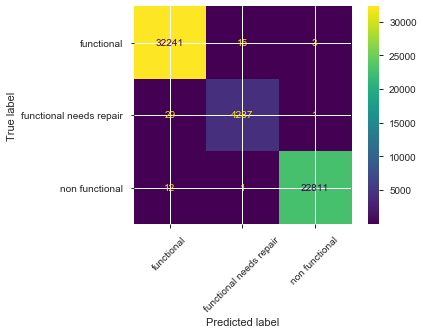

In [37]:
plot_confusion_matrix(pipeline, 
                           X_train, 
                           y_train, 
                           values_format='.0f', 
                           xticks_rotation=45);

In [39]:
# Submit 

y_pred = pipeline.predict(X_test)

submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('/Users/josemarquez/Desktop/jose-marquez_kagSub4', index=False)